In [1]:
%load_ext autoreload
%autoreload 2

import os
import tempfile

from urllib import request
import pandas as pd
import numpy as np
import seaborn as sns

from keras_transfer_learning import data, utils

Using TensorFlow backend.


# Prepare the ground truth

In [2]:
# Load the ground truth
# Create temp dir
tempdir_obj = tempfile.TemporaryDirectory()
tempdir = tempdir_obj.name

# Load the ground truth for the test set
csv_file_solution = os.path.join(tempdir, 'stage2_solution_final.csv')
request.urlretrieve(
    'https://data.broadinstitute.org/bbbc/BBBC038/stage2_solution_final.csv',
    csv_file_solution)
solution_df = pd.read_csv(csv_file_solution)
# Do not use ignored files
solution_df = solution_df[solution_df['Usage'] == 'Private']

In [3]:
# Get the unique image ids
image_ids = sorted(solution_df['ImageId'].unique())

In [4]:
# Load the images
test_imgs_list = data.utils._load_tifs_from_dir_sorted(os.path.join('data', 'dsb2018', 'test', 'images'))
test_imgs = { k: v for k, v in zip(image_ids, test_imgs_list)}

In [5]:
def decode_pixels_dsb2018(encoded_pixels_list, shape):
    mask = np.zeros(shape, dtype='uint16')
    for idx, pixels_str in enumerate(encoded_pixels_list, 1):
        pixels = []
        pixel_pairs = np.array(
            [int(idx) for idx in pixels_str.split(' ')]).reshape(-1, 2) - 1
        for pair in pixel_pairs:
            pixels.extend(list(range(pair[0], pair[0] + pair[1])))

        rows = np.mod(pixels, shape[0])
        cols = np.floor_divide(pixels, shape[0])
        if rows.size == 0:
            print("WARNING: rows empty for test image {}.".format(idx))
            continue
        if cols.size == 0:
            print("WARNING: rows empty for test image {}.".format(idx))
            continue

        elif np.any(mask[rows, cols] > 0):
            print(
                "WARNING: Found overlapping cells in test image {}.".format(idx))

        mask[rows, cols] = idx
    
    return mask

In [6]:
def reconstruct_masks(df, image_ids, images):
    masks = {}
    for image_id in image_ids:
        enc_pixels_list = df[df['ImageId'] == image_id]['EncodedPixels'].tolist()
        masks[image_id] = decode_pixels_dsb2018(enc_pixels_list, images[image_id].shape)
    return masks

In [7]:
# Loop over the images reconstruct the gt labelings
solution_masks = reconstruct_masks(solution_df, image_ids, test_imgs)

# Compute mAP for a submission

In [8]:
def map_of_submission(file, iou_thresholds=None):
    if iou_thresholds is None:
        iou_thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    # Load the submission
    result_df = pd.read_csv(file)
    # Create the predicted masks
    result_masks = reconstruct_masks(result_df, image_ids, test_imgs)

    # Compute the mAP
    results_masks_list = [result_masks[k] for k in image_ids]
    solution_masks_list = [solution_masks[k] for k in image_ids]
    iou_thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
    return utils.mean_average_precision.ap_segm(results_masks_list, solution_masks_list, iou_thresholds)

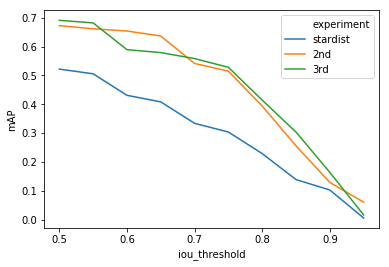

In [9]:
mAPs_stardist = map_of_submission(os.path.join('models', 'C02_unet_stardist_dsb2018_R_F', 'submission.csv'))
mAPs_2nd_place = map_of_submission(os.path.join('submission_dsb2018_2nd_place.csv'))
mAPs_3rd_place = map_of_submission(os.path.join('submission_dsb2018_3rd_place.csv'))

iou_thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
mAP = mAPs_stardist + mAPs_2nd_place + mAPs_3rd_place
iou_threshold = iou_thresholds * 3
experiment = ['stardist'] * len(iou_thresholds) + ['2nd'] * len(iou_thresholds) + ['3rd'] * len(iou_thresholds)
df = pd.DataFrame({'experiment': experiment, 'mAP': mAP, 'iou_threshold': iou_threshold})

plot = sns.lineplot(x='iou_threshold', y='mAP', hue='experiment', data=df)